### KNN(K-Nearst Neighbors)

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from gensim.parsing.preprocessing import preprocess_string
from gensim.models import Word2Vec

# Mevcut datayı listeler
for dirname, _, filenames in os.walk('/kaggle/input/stanford-question-answering-dataset/train-v1.1.json'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Veriyi yükleme fonksiyonu
def squad_json_to_dataframe(file_path, record_path=['data', 'paragraphs', 'qas', 'answers']):
    file = json.loads(open(file_path).read())
    js = pd.json_normalize(file, record_path)
    m = pd.json_normalize(file, record_path[:-1])
    r = pd.json_normalize(file, record_path[:-2])
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    data = m[['id', 'question', 'context', 'answers']].set_index('id').reset_index()
    data['c_id'] = data['context'].factorize()[0]
    return data

# Veriyi yükleme
file_path = '/kaggle/input/stanford-question-answering-dataset/train-v1.1.json'
data = squad_json_to_dataframe(file_path)


In [2]:
# TF-IDF Tanımlama
tfidf_configs = {
    'lowercase': True,
    'analyzer': 'word',
    'stop_words': 'english',
    'binary': True,
    'max_df': 0.9,
    'max_features': 10_000
}
retriever_configs = {
    'n_neighbors': 10,
    'metric': 'cosine'
}

# Pipelinemızı tanımlama
embedding = TfidfVectorizer(**tfidf_configs)
retriever = NearestNeighbors(**retriever_configs)

# Model eğitimi
documents = data[['context', 'c_id']].drop_duplicates().reset_index(drop=True)
X = embedding.fit_transform(documents['context'])
retriever.fit(X, documents['c_id'])

# Soruyu Vektörleştirme ve Benzer Belgeleri Bulma
def transform_text(vectorizer, text):
    vector = vectorizer.transform([text])
    return vectorizer.inverse_transform(vector)

question = "What is in front of the Notre Dame Main Building?"
X_question = embedding.transform([question])
c_id = retriever.kneighbors(X_question, return_distance=False)[0][0]
selected = documents.iloc[c_id]['context']

print('Question:', question)
print('Selected Context:', selected)


Question: What is in front of the Notre Dame Main Building?
Selected Context: The library system of the university is divided between the main library and each of the colleges and schools. The main building is the 14-story Theodore M. Hesburgh Library, completed in 1963, which is the third building to house the main collection of books. The front of the library is adorned with the Word of Life mural designed by artist Millard Sheets. This mural is popularly known as "Touchdown Jesus" because of its proximity to Notre Dame Stadium and Jesus' arms appearing to make the signal for a touchdown.


In [3]:
def visualize_qa_context(data, num_samples=5):
    sample_data = data.sample(num_samples)
    questions = sample_data['question'].values
    contexts = sample_data['context'].values
    answers = [ans['text'][0] if len(ans['text']) > 0 else 'No Answer' for ans in sample_data['answers'].values]
    
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        sns.set(style="whitegrid")
        plt.title(f"Q: {questions[i]}")
        plt.text(0.5, 0.5, f"Context: {contexts[i][:300]}...\nAnswer: {answers[i]}", ha='center', va='center', wrap=True)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


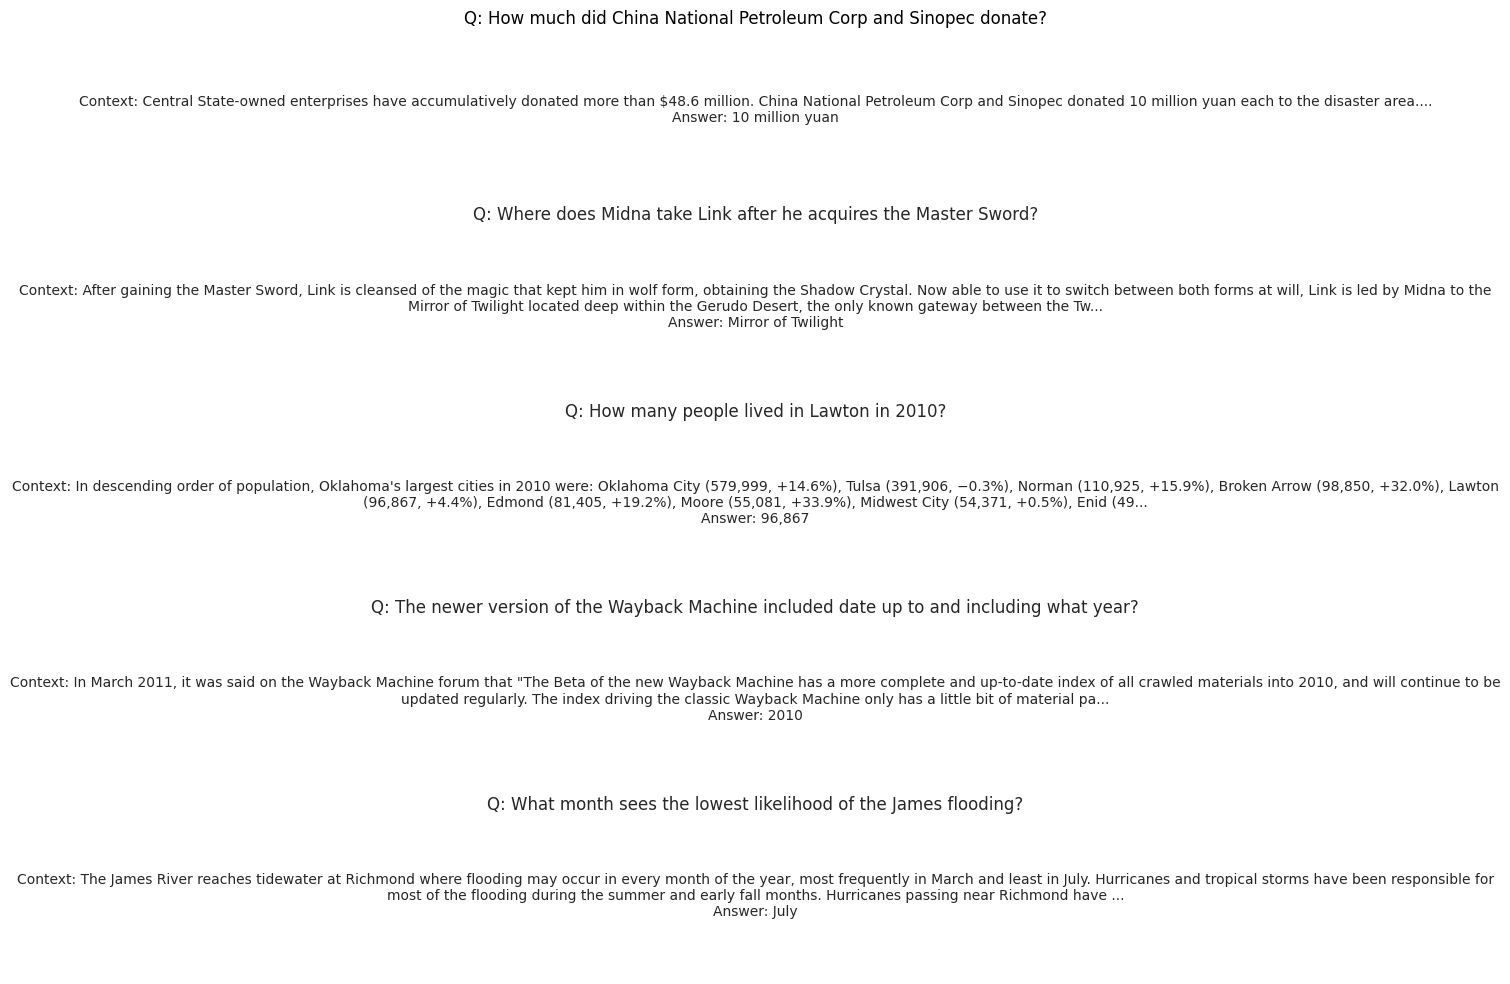

In [4]:
def visualize_qa_context(data, num_samples=5):
    sample_data = data.sample(num_samples)
    questions = sample_data['question'].values
    contexts = sample_data['context'].values
    answers = [ans[0]['text'] if len(ans) > 0 else 'No Answer' for ans in sample_data['answers']]
    
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        sns.set(style="whitegrid")
        plt.title(f"Q: {questions[i]}", fontsize=12)
        plt.text(0.5, 0.5, f"Context: {contexts[i][:300]}...\nAnswer: {answers[i]}", 
                 ha='center', va='center', wrap=True, fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Görselleştirme
visualize_qa_context(data, num_samples=5)


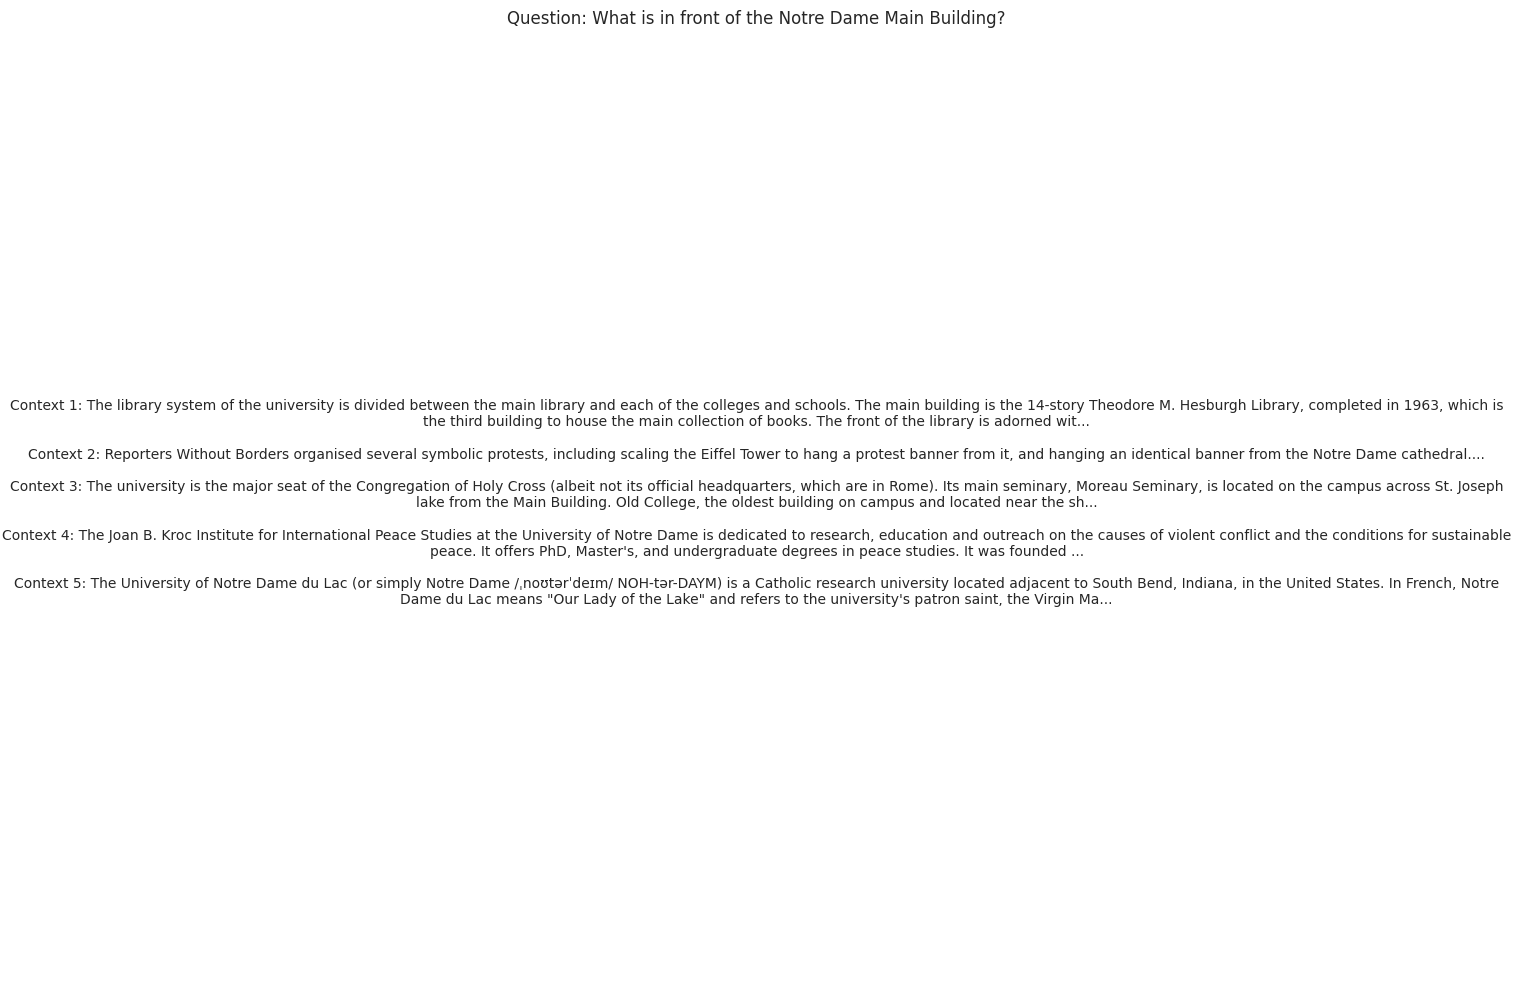

In [5]:
# Soru vektörleştirme ve benzer belgeleri bulma
def retrieve_similar_documents(question, vectorizer, retriever, documents, num_results=5):
    X_question = vectorizer.transform([question])
    c_ids = retriever.kneighbors(X_question, return_distance=False)[0][:num_results]
    selected_contexts = documents.iloc[c_ids]['context'].values
    return selected_contexts

# Soruyu ve benzer belgeleri görselleştirme
def visualize_retrieved_documents(question, selected_contexts):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 1, 1)
    sns.set(style="whitegrid")
    plt.title(f"Question: {question}", fontsize=12)
    context_text = "\n\n".join([f"Context {i+1}: {context[:300]}..." for i, context in enumerate(selected_contexts)])
    plt.text(0.5, 0.5, context_text, ha='center', va='center', wrap=True, fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Soruyu ve benzer belgeleri al ve görselleştir
question = "What is in front of the Notre Dame Main Building?"
selected_contexts = retrieve_similar_documents(question, embedding, retriever, documents)
visualize_retrieved_documents(question, selected_contexts)


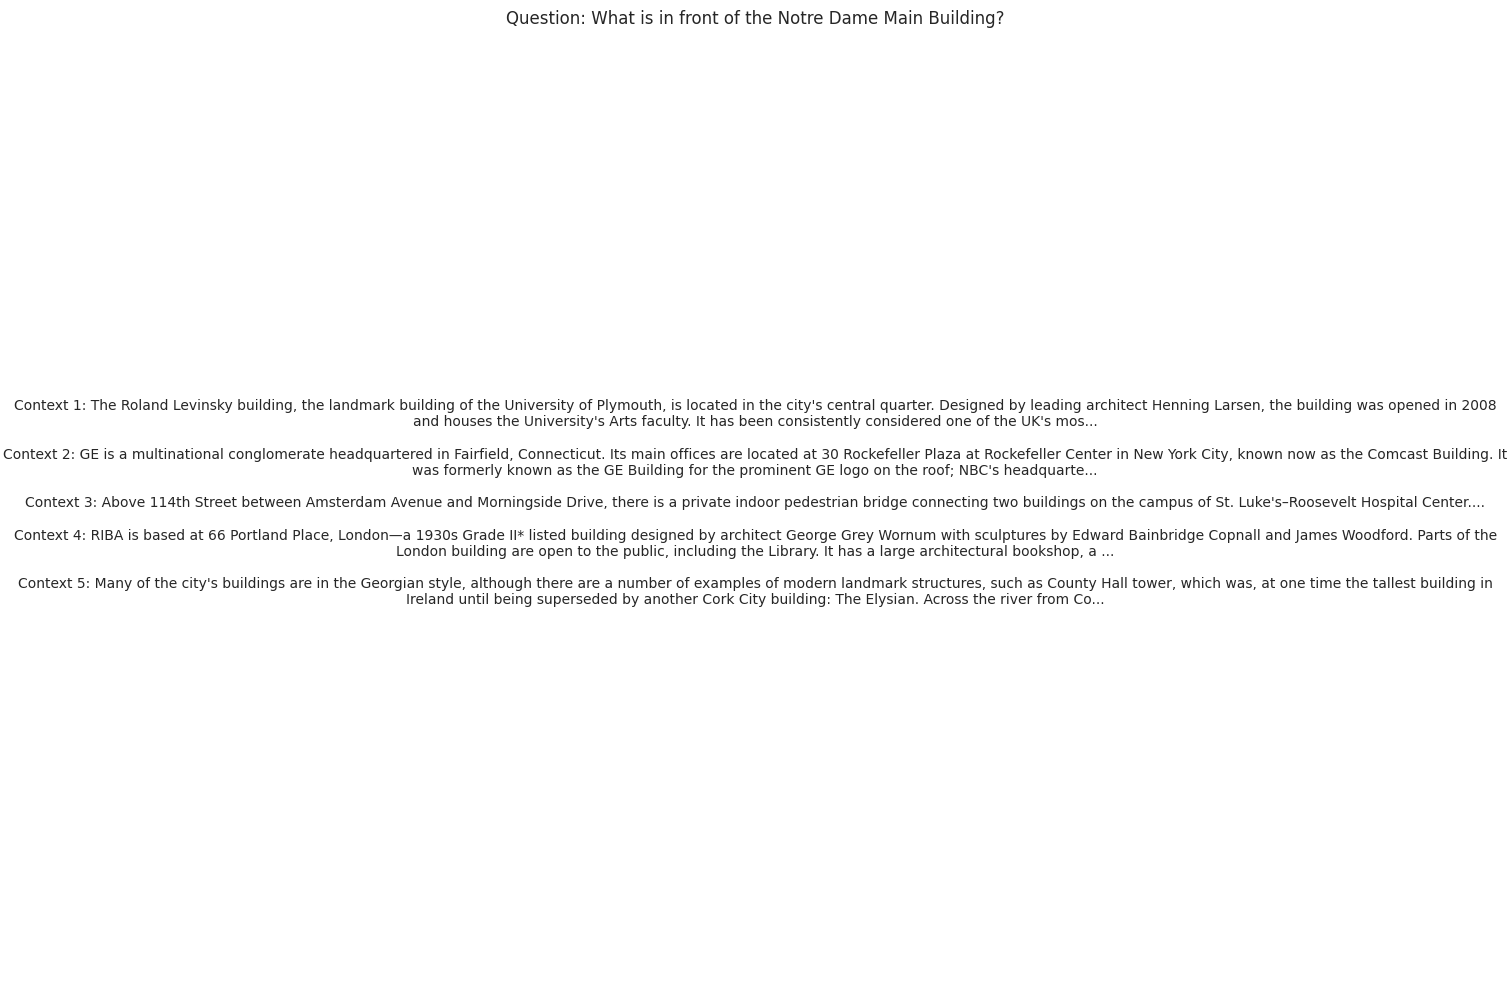

In [6]:
# Word2Vec eğitimi
corpus = documents['context'].tolist()
corpus = [preprocess_string(t) for t in corpus]
vectorizer = Word2Vec(sentences=corpus, vector_size=300, window=5, min_count=1, workers=4).wv

# Soru vektörleştirme ve benzer belgeleri bulma
def transform_text2(vectorizer, text):
    tokens = preprocess_string(text)
    words = [vectorizer[w] for w in tokens if w in vectorizer]
    return np.mean(words, axis=0) if len(words) > 0 else np.zeros((300,), dtype=np.float32)

def retrieve_similar_documents_word2vec(question, vectorizer, retriever, documents, num_results=5):
    X_question = transform_text2(vectorizer, question)
    c_ids = retriever.kneighbors([X_question], return_distance=False)[0][:num_results]
    selected_contexts = documents.iloc[c_ids]['context'].values
    return selected_contexts

# Model eğitimi
X = documents['context'].apply(lambda x: transform_text2(vectorizer, x)).tolist()
retriever2 = NearestNeighbors(**retriever_configs)
retriever2.fit(X, documents['c_id'])

# Soruyu ve benzer belgeleri al ve görselleştir
selected_contexts_word2vec = retrieve_similar_documents_word2vec(question, vectorizer, retriever2, documents)
visualize_retrieved_documents(question, selected_contexts_word2vec)

In [7]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from gensim.parsing.preprocessing import preprocess_string
from gensim.models import Word2Vec
import os


# Mevcut datayı listeleme
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Veriyi yükleme fonksiyonu
def squad_json_to_dataframe(file_path, record_path=['data', 'paragraphs', 'qas', 'answers']):
    file = json.loads(open(file_path).read())
    js = pd.json_normalize(file, record_path)
    m = pd.json_normalize(file, record_path[:-1])
    r = pd.json_normalize(file, record_path[:-2])
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    data = m[['id', 'question', 'context', 'answers']].set_index('id').reset_index()
    data['c_id'] = data['context'].factorize()[0]
    return data

# Veriyi yükleme
file_path = '/kaggle/input/stanford-question-answering-dataset/train-v1.1.json'
data = squad_json_to_dataframe(file_path)



/kaggle/input/stanford-question-answering-dataset/train-v1.1.json
/kaggle/input/stanford-question-answering-dataset/dev-v1.1.json
/kaggle/input/nlp-pc/QAworkflow.png


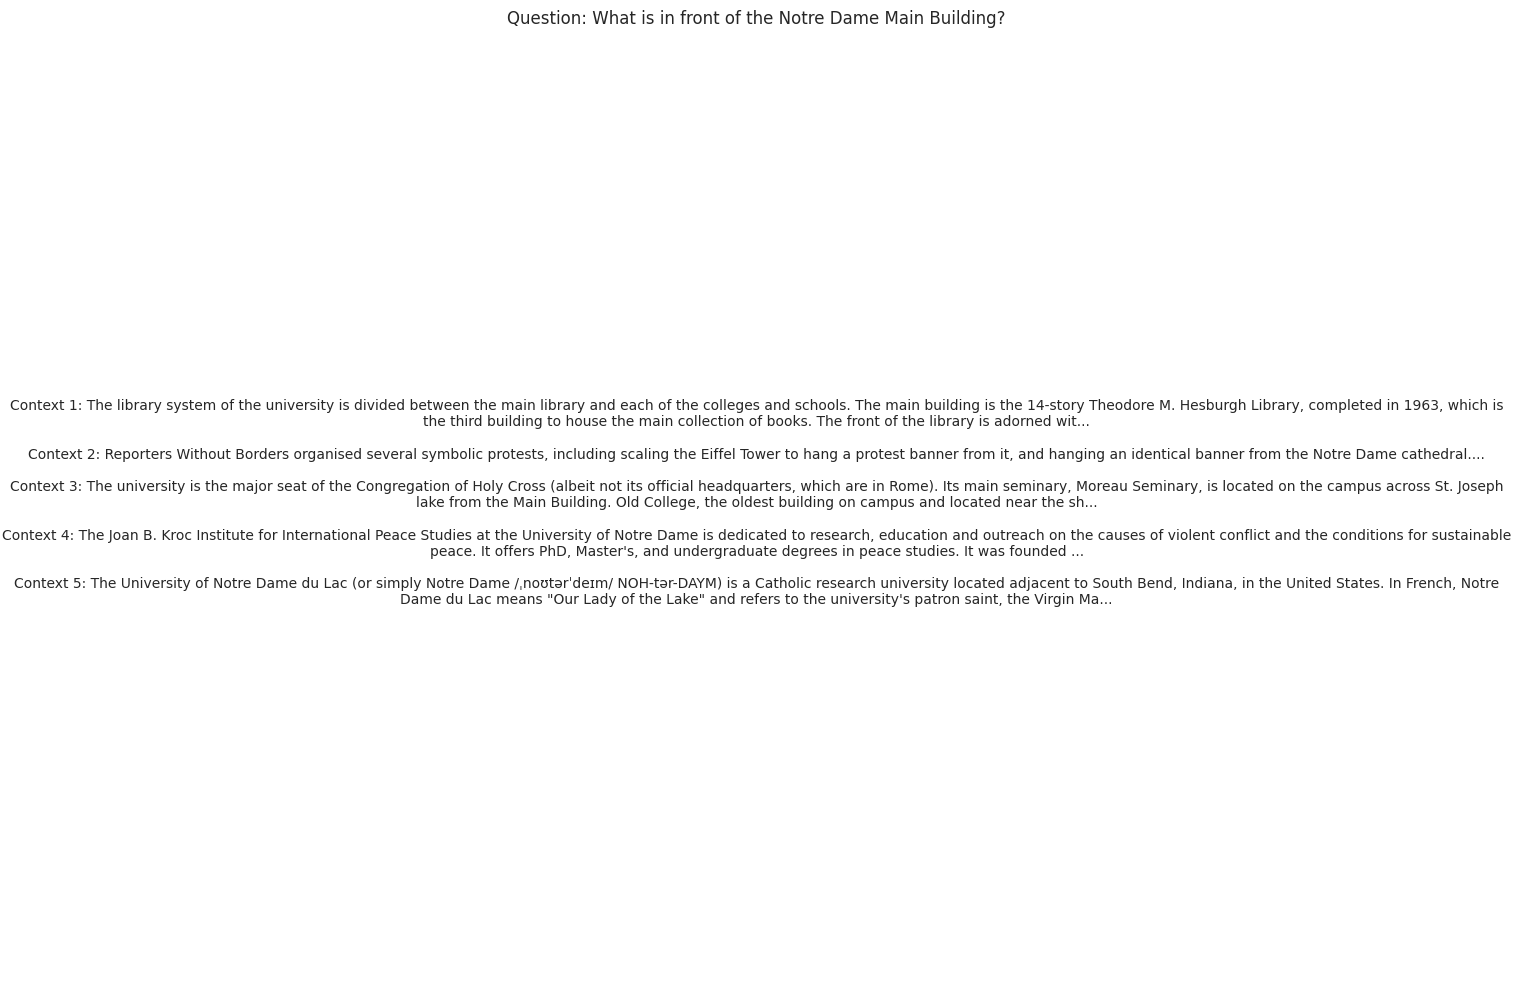

In [8]:
# TF-IDF Tanımlama
tfidf_configs = {
    'lowercase': True,
    'analyzer': 'word',
    'stop_words': 'english',
    'binary': True,
    'max_df': 0.9,
    'max_features': 10_000
}
retriever_configs = {
    'n_neighbors': 10,
    'metric': 'cosine'
}

# Pipelinemızı tanımlama
embedding = TfidfVectorizer(**tfidf_configs)
retriever = NearestNeighbors(**retriever_configs)

# Model eğitimi
documents = data[['context', 'c_id']].drop_duplicates().reset_index(drop=True)
X = embedding.fit_transform(documents['context'])
retriever.fit(X, documents['c_id'])

# Soru vektörleştirme ve benzer belgeleri bulma
def retrieve_similar_documents(question, vectorizer, retriever, documents, num_results=5):
    X_question = vectorizer.transform([question])
    c_ids = retriever.kneighbors(X_question, return_distance=False)[0][:num_results]
    selected_contexts = documents.iloc[c_ids]['context'].values
    return selected_contexts

# Soruyu ve benzer belgeleri görselleştirme
def visualize_retrieved_documents(question, selected_contexts):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 1, 1)
    sns.set(style="whitegrid")
    plt.title(f"Question: {question}", fontsize=12)
    context_text = "\n\n".join([f"Context {i+1}: {context[:300]}..." for i, context in enumerate(selected_contexts)])
    plt.text(0.5, 0.5, context_text, ha='center', va='center', wrap=True, fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Soruyu ve benzer belgeleri alma ve görselleştirme
question = "What is in front of the Notre Dame Main Building?"
selected_contexts = retrieve_similar_documents(question, embedding, retriever, documents)
visualize_retrieved_documents(question, selected_contexts)


Accuracy: 0.7148
Miktar: 62615 from 87599


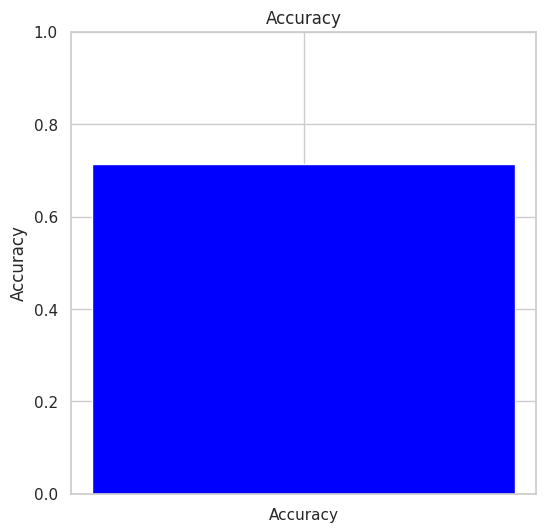

In [9]:
def top_accuracy(y_true, y_pred) -> float:
    right, count = 0, 0
    for i, y_t in enumerate(y_true):
        count += 1
        if y_t in y_pred[i]:
            right += 1
    return right / count if count > 0 else 0

# Her soru için dökümanları tahmin etme
X_test = embedding.transform(data['question'])
y_test = data['c_id']
y_pred = retriever.kneighbors(X_test, return_distance=False)

# Accuracy hesaplama
acc = top_accuracy(y_test, y_pred)
print('Accuracy:', f'{acc:.4f}')
print('Miktar:', int(acc*len(y_pred)), 'from', len(y_pred))

# Accuracy görselleştirme
def visualize_accuracy(y_test, y_pred):
    acc = top_accuracy(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    plt.title('Accuracy')
    plt.bar(['Accuracy'], [acc], color=['blue'])
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.show()

visualize_accuracy(y_test, y_pred)


Word2Vec Accuracy: 0.1205
Miktar: 10559 from 87599


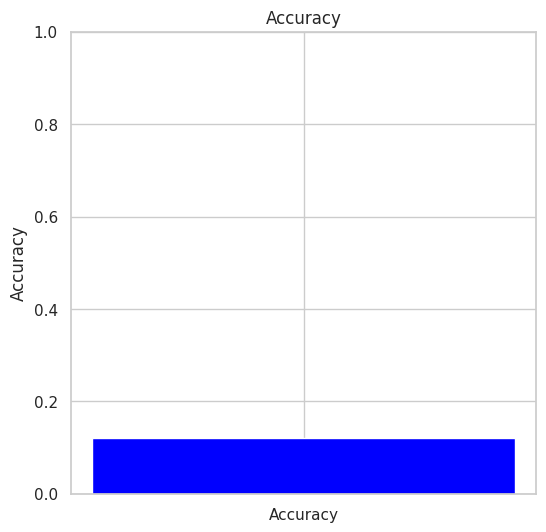

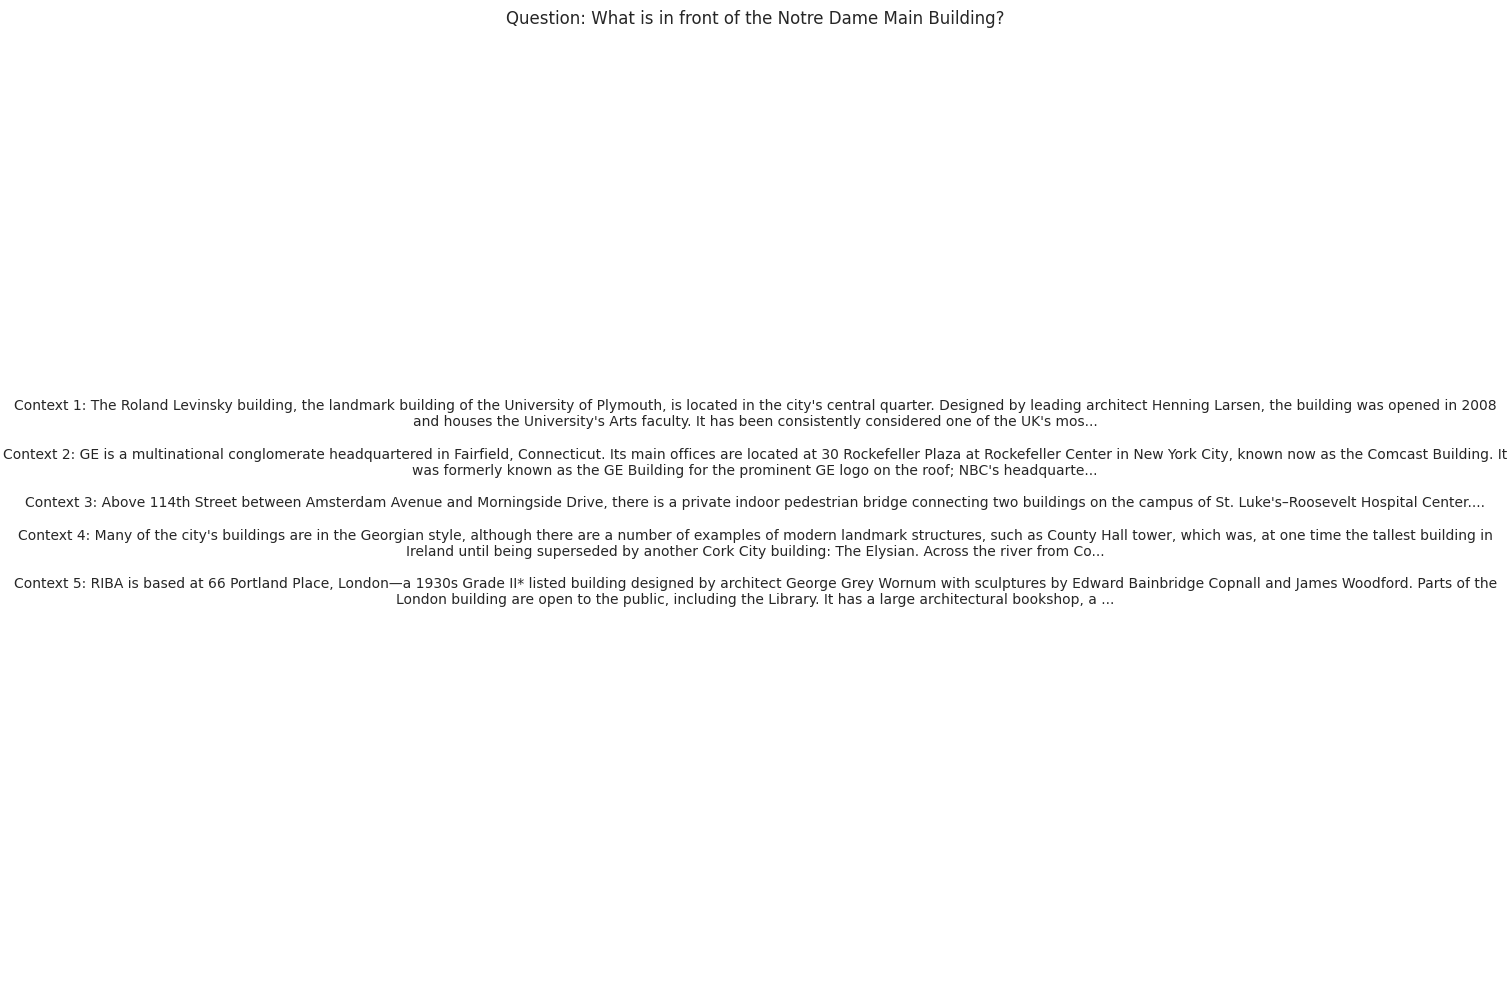

In [10]:
# Word2Vec eğitimi
corpus = documents['context'].tolist()
corpus = [preprocess_string(t) for t in corpus]
vectorizer = Word2Vec(sentences=corpus, vector_size=300, window=5, min_count=1, workers=4).wv

# Soru vektörleştirme ve benzer belgeleri bulma
def transform_text2(vectorizer, text):
    tokens = preprocess_string(text)
    words = [vectorizer[w] for w in tokens if w in vectorizer]
    return np.mean(words, axis=0) if len(words) > 0 else np.zeros((300,), dtype=np.float32)

def retrieve_similar_documents_word2vec(question, vectorizer, retriever, documents, num_results=5):
    X_question = transform_text2(vectorizer, question)
    c_ids = retriever.kneighbors([X_question], return_distance=False)[0][:num_results]
    selected_contexts = documents.iloc[c_ids]['context'].values
    return selected_contexts

# Model eğitimi
X = documents['context'].apply(lambda x: transform_text2(vectorizer, x)).tolist()
retriever2 = NearestNeighbors(**retriever_configs)
retriever2.fit(X, documents['c_id'])

# Her soru için dökümanları tahmin etme
X_test_word2vec = data['question'].apply(lambda x: transform_text2(vectorizer, x)).tolist()
y_pred_word2vec = retriever2.kneighbors(X_test_word2vec, return_distance=False)

# Accuracy hesaplama
acc_word2vec = top_accuracy(y_test, y_pred_word2vec)
print('Word2Vec Accuracy:', f'{acc_word2vec:.4f}')
print('Miktar:', int(acc_word2vec*len(y_pred_word2vec)), 'from', len(y_pred_word2vec))

# Accuracy görselleştirme
visualize_accuracy(y_test, y_pred_word2vec)

# Soruyu ve benzer belgeleri al ve görselleştir
selected_contexts_word2vec = retrieve_similar_documents_word2vec(question, vectorizer, retriever2, documents)
visualize_retrieved_documents(question, selected_contexts_word2vec)


### XGBOOST ve Random Forest(Rastgele Orman)

In [11]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from gensim.parsing.preprocessing import preprocess_string
from gensim.models import Word2Vec
import os

# Mevcut datayı listeler
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Veriyi yükleme fonksiyonu
def squad_json_to_dataframe(file_path, record_path=['data', 'paragraphs', 'qas', 'answers']):
    file = json.loads(open(file_path).read())
    js = pd.json_normalize(file, record_path)
    m = pd.json_normalize(file, record_path[:-1])
    r = pd.json_normalize(file, record_path[:-2])
    idx = np.repeat(r['context'].values, r.qas.str.len())
    m['context'] = idx
    data = m[['id', 'question', 'context', 'answers']].set_index('id').reset_index()
    data['c_id'] = data['context'].factorize()[0]
    return data

# Veriyi yükleme
file_path = '/kaggle/input/stanford-question-answering-dataset/train-v1.1.json'
data = squad_json_to_dataframe(file_path)


/kaggle/input/stanford-question-answering-dataset/train-v1.1.json
/kaggle/input/stanford-question-answering-dataset/dev-v1.1.json
/kaggle/input/nlp-pc/QAworkflow.png


### TF-IDF ile Vektörleştirme ve Modellerin Eğitimi

In [12]:
# TF-IDF Tanımlama
tfidf_configs = {
    'lowercase': True,
    'analyzer': 'word',
    'stop_words': 'english',
    'binary': True,
    'max_df': 0.9,
    'max_features': 10_000
}

# Pipelinemızı tanımlama
embedding = TfidfVectorizer(**tfidf_configs)

# Model eğitimi
documents = data[['context', 'c_id']].drop_duplicates().reset_index(drop=True)
X_train = embedding.fit_transform(documents['context'])
y_train = documents['c_id']

# Random Forest model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# XGBoost model
model_xgb = xgb.XGBClassifier(n_estimators=100, random_state=42)
model_xgb.fit(X_train, y_train)


### Soru Vektörleştirme ve Belge Alma

In [ ]:
# Soru vektörleştirme ve benzer belgeleri bulma
def retrieve_similar_documents(model, question, vectorizer, documents, num_results=5):
    X_question = vectorizer.transform([question])
    y_pred_proba = model.predict_proba(X_question)
    top_indices = np.argsort(y_pred_proba[0])[::-1][:num_results]
    selected_contexts = documents.iloc[top_indices]['context'].values
    return selected_contexts

# Soruyu ve benzer belgeleri görselleştirme
def visualize_retrieved_documents(question, selected_contexts):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 1, 1)
    sns.set(style="whitegrid")
    plt.title(f"Question: {question}", fontsize=12)
    context_text = "\n\n".join([f"Context {i+1}: {context[:300]}..." for i, context in enumerate(selected_contexts)])
    plt.text(0.5, 0.5, context_text, ha='center', va='center', wrap=True, fontsize=10)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Soruyu ve benzer belgeleri al ve görselleştir
question = "What is in front of the Notre Dame Main Building?"
selected_contexts_rf = retrieve_similar_documents(model_rf, question, embedding, documents)
visualize_retrieved_documents(question, selected_contexts_rf)

selected_contexts_xgb = retrieve_similar_documents(model_xgb, question, embedding, documents)
visualize_retrieved_documents(question, selected_contexts_xgb)


### Accuracy Hesaplama ve Görselleştirme

In [ ]:
def top_accuracy(y_true, y_pred) -> float:
    right, count = 0, 0
    for i, y_t in enumerate(y_true):
        count += 1
        if y_t in y_pred[i]:
            right += 1
    return right / count if count > 0 else 0

# Her soru için dökümanları tahmin etme
X_test = embedding.transform(data['question'])
y_test = data['c_id']

# Random Forest ile tahmin
y_pred_proba_rf = model_rf.predict_proba(X_test)
y_pred_rf = [np.argsort(pred)[::-1][:10] for pred in y_pred_proba_rf]

# XGBoost ile tahmin
y_pred_proba_xgb = model_xgb.predict_proba(X_test)
y_pred_xgb = [np.argsort(pred)[::-1][:10] for pred in y_pred_proba_xgb]

# Accuracy hesaplama
acc_rf = top_accuracy(y_test, y_pred_rf)
print('Random Forest Accuracy:', f'{acc_rf:.4f}')
print('Miktar:', int(acc_rf*len(y_pred_rf)), 'from', len(y_pred_rf))

acc_xgb = top_accuracy(y_test, y_pred_xgb)
print('XGBoost Accuracy:', f'{acc_xgb:.4f}')
print('Miktar:', int(acc_xgb*len(y_pred_xgb)), 'from', len(y_pred_xgb))

# Accuracy görselleştirme
def visualize_accuracy(acc_rf, acc_xgb):
    plt.figure(figsize=(6, 6))
    plt.title('Accuracy Comparison')
    plt.bar(['Random Forest', 'XGBoost'], [acc_rf, acc_xgb], color=['blue', 'green'])
    plt.ylim(0, 1)
    plt.ylabel('Accuracy')
    plt.show()

visualize_accuracy(acc_rf, acc_xgb)


### Word2Vec ile Belge Alma ve Değerlendirme

In [ ]:
# Word2Vec eğitimi
corpus = documents['context'].tolist()
corpus = [preprocess_string(t) for t in corpus]
vectorizer = Word2Vec(sentences=corpus, vector_size=300, window=5, min_count=1, workers=4).wv

# Soru vektörleştirme ve benzer belgeleri bulma
def transform_text2(vectorizer, text):
    tokens = preprocess_string(text)
    words = [vectorizer[w] for w in tokens if w in vectorizer]
    return np.mean(words, axis=0) if len(words) > 0 else np.zeros((300,), dtype=np.float32)

def retrieve_similar_documents_word2vec(model, question, vectorizer, documents, num_results=5):
    X_question = transform_text2(vectorizer, question).reshape(1, -1)
    y_pred_proba = model.predict_proba(X_question)
    top_indices = np.argsort(y_pred_proba[0])[::-1][:num_results]
    selected_contexts = documents.iloc[top_indices]['context'].values
    return selected_contexts

# Model eğitimi
X_train_word2vec = documents['context'].apply(lambda x: transform_text2(vectorizer, x)).tolist()
